In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf

%matplotlib inline
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## 函数数据生成

https://deepxde.readthedocs.io/en/latest/modules/deepxde.geometry.html

https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html

一元函数$x\in \mathbb{R}$：$$y = x \sin(5 x), \,\,\,\, x\in [-1,1]$$

In [75]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)

geom = dde.geometry.Interval(-1, 1) # geom = dde.geometry.geometry_1d.Interval(-1,1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test) # 均匀采样 np.linspace(-1, 1, num)

In [76]:
len(data.train_next_batch()), len(data.test())

(2, 2)

In [77]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape  # 参数 batch_size 并没有什么用

((16, 1), (16, 1))

In [78]:
data.test()[0].shape, data.test()[1].shape

((100, 1), (100, 1))

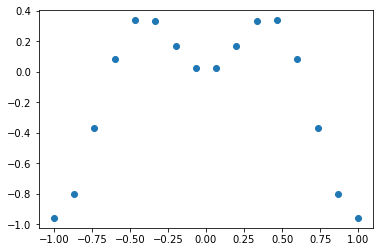

In [79]:
# plt.figure(figsize = (5, 5))
x,y = data.train_next_batch()
# plt.plot(x, y)
plt.scatter(x, y)

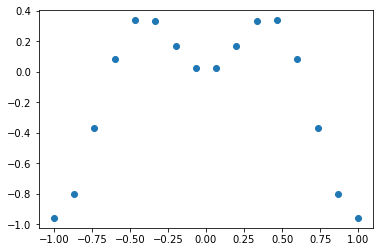

In [83]:
x_ = np.linspace(-1, 1, num_train)
# x_ = np.linspace(-1, 1, num_test)
y_ = func(x_)
# plt.plot(x_, y_)
plt.scatter(x_, y_)

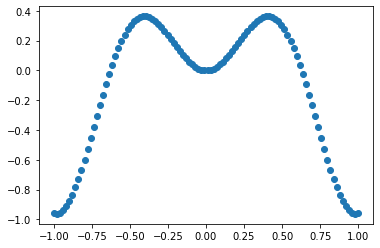

In [82]:
test_x,test_y = data.test()
# plt.plot(test_x,test_y)
plt.scatter(test_x,test_y)

二元函数$x\in \mathbb{R}^2$：$$y = (x_1+x_2)^2, x_i\in [-1,1]$$

In [159]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return (x[:,0]+x[:,1])*(x[:,0]+x[:,1])

# geom = dde.geometry.geometry_2d.Disk(center=(0,0), radius=1)
geom = dde.geometry.geometry_2d.Rectangle(xmin=(-1,-1), xmax=(1,1))
# geom = dde.geometry.geometry_2d.Triangle((-1,-1), (-1,1), (1,0))
# geom = dde.geometry.geometry_2d.Polygon(vertices=[(-1,-1), (1,-1), (3,0), (1,1), (-1,1)])
num_train = 100
num_test = 200
data = dde.data.Function(geom, func, num_train, num_test)

In [160]:
len(data.train_next_batch()), len(data.test())    # Warning，num_test变多了，这是由采样方法造成的差异

(2, 2)

In [161]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape

((100, 2), (100,))

In [162]:
data.test()[0].shape, data.test()[1].shape

((225, 2), (225,))

In [ ]:
x,y = data.train_next_batch()
# x,y = data.test()


# plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
# ax.plot3D(x[:,0], x[:,1],y)
ax.scatter3D(x[:,0], x[:,1],y)

三元函数$x\in \mathbb{R}^3$：$$y = (x_1+x_2+x_3)^2, x_i\in [-1,1]$$

In [192]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return tf.pow(tf.reduce_sum(x, axis=[1]),2)

geom = dde.geometry.geometry_3d.Cuboid(xmin=(-1,-1,-1), xmax=(1,1,1))
# geom = dde.geometry.geometry_3d.Sphere(center=(0,0,0), radius=2)

num_train = 1000
num_test = 800
data = dde.data.Function(geom, func, num_train, num_test)

In [193]:
len(data.train_next_batch()), len(data.test())

(2, 2)

In [194]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape

((1000, 3), TensorShape([1000]))

In [195]:
data.test()[0].shape, data.test()[1].shape

((1000, 3), TensorShape([1000]))

n元函数$x\in \mathbb{R}^n$：$$y = (\sum^n_{i=1}x_i)^2, x_i\in [-1,1]$$

In [10]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return tf.pow(tf.reduce_sum(x, axis=[1]),2)

n = 100

# geom = dde.geometry.geometry_nd.Hypercube(xmin=-np.ones(n), xmax=np.ones(n))  
# Hypercube 的高维实现是否有问题  n<20出结果比较快，n>30就崩溃

geom = dde.geometry.geometry_nd.Hypersphere(center=np.zeros(n), radius=np.sqrt(sum(np.ones(n))))

num_train = 100
num_test = 80
data = dde.data.Function(geom, func, num_train, num_test)

data.train_next_batch()[0].shape, data.train_next_batch()[1].shape

((100, 100000), TensorShape([100]))

In [9]:
len(data.train_next_batch()), len(data.test())

(2, 2)

In [7]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape

((100, 1000), TensorShape([100]))

In [218]:
data.test()[0].shape, data.test()[1].shape

((800, 100), TensorShape([800]))

## 偏微分方程数据生成

一维描述：

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichletperiodic.html

We will solve a Poisson equation 我们将求解一个泊松方程:
$$\large -\Delta u = \pi^2 \sin(\pi x), x \in [-1,1]$$

with the Dirichlet boundary conditions 与狄利克雷边界条件:$\large u(-1) = 0, u(1) = 0$

The exact solution is 精确解: $\large u(x) = \sin(\pi x)$.


mathematica求解代码：
```mathematica
LaplaceEquation = -D[u[x], {x, 2}] == Pi^2 * Sin[Pi*x];
DSolve[{LaplaceEquation, u[-1] == 0, u[1] == 0}, u[x], x]
```

In [65]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

In [66]:
len(data.train_next_batch()), len(data.test())

(3, 3)

In [67]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape, data.train_next_batch()[2]

((20, 1), (20, 1), None)

In [68]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.050794 s

'compile' took 0.401603 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.65e+01, 3.65e-03]    [4.91e+01, 3.65e-03]    [9.61e-01]    
1000      [1.19e-04, 2.91e-08]    [2.55e-04, 2.91e-08]    [7.37e-04]    

Best model at step 1000:
  train loss: 1.19e-04
  test loss: 2.55e-04
  test metric: [7.37e-04]

'train' took 3.924833 s



n维描述：

We will solve a Poisson equation 我们将求解一个泊松方程:
$$\large -\Delta u = -\sum^n_{i=1} \frac{\partial^2 u}{\partial x_i^2} = \pi^2 \sum^n_{i=1}\sin(\pi x_i), x_i \in [-1,1]$$


with the Dirichlet boundary conditions 与狄利克雷边界条件:$\large u(x_i=-1) = 0, u(x_i=1) = 0$

The exact solution is 精确解: $\large u(\boldsymbol{x}) = \sum^n_{i=1}\sin(\pi x_i)$.

mathematica求解代码：
```mathematica
LaplaceEquation = -D[u[x], {x, 2}] == Pi^2 * Sin[Pi*x];
DSolve[{LaplaceEquation, u[-1] == 0, u[1] == 0}, u[x], x]
```

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.reduce_sum(tf.sin(np.pi * x), axis=1)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.add.reduce(np.sin(np.pi * x),axis=1,keepdims=True)


n = 100 # train_distribution="pseudo"
# geom = dde.geometry.geometry_nd.Hypercube(xmin=-np.ones(n), xmax=np.ones(n)) 
geom = dde.geometry.geometry_nd.Hypersphere(center=np.zeros(n), radius=np.sqrt(sum(np.ones(n))))

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)
data = dde.data.PDE(geom, pde, bc, 100, 80, train_distribution="pseudo", solution=func, num_test=100)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
len(data.train_next_batch()), len(data.test())

(3, 3)

In [3]:
data.train_next_batch()[0].shape, data.train_next_batch()[1].shape, data.train_next_batch()[2]

((260, 100), (260, 1), None)

In [4]:
layer_size = [n] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.115940 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 5.919905 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [3.92e+03, 2.66e-01]    [4.31e+03, 2.66e-01]    [9.94e-01]    
1000      [3.86e+03, 1.59e-11]    [4.33e+03, 1.59e-11]    [1.02e+00]    

Best model at step 1000:
  train loss: 3.86e+03
  test loss: 4.33e+03
  test metric: [1.02e+00]

'train' took 7.291901 s

